In [1]:
import anndata
import h5py
from geosketch import gs
from fbpca import pca
import numpy as np
import pegasus
import seaborn as sns

In [2]:
sns.set_theme(style="ticks", palette="pastel")

In [3]:
# data = h5py.File("test.h5")
# X = data['samp_data']['data'][:,:]
# X.shape

In [4]:
# dataset from 10x genomics
data =  anndata.read_h5ad("V1_Human_Lymph_Node.h5ad")
data

AnnData object with n_obs × n_vars = 3962 × 18467
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Pegasus signature score before sketch

In [5]:
pegasus.calc_signature_score(data, signatures="ribosomal_genes_human")

2021-10-08 17:14:54,735 - pegasus.tools.signature_score - INFO - Loaded signatures from GMT file /Users/kancherj/opt/miniconda3/envs/sketch/lib/python3.9/site-packages/pegasus/data_files/ribosomal_genes_human.gmt.
2021-10-08 17:14:54,737 - pegasus.tools.signature_score - INFO - Signature ribo_genes: 77 out of 78 genes are used in signature score calculation.
2021-10-08 17:14:54,803 - pegasus.tools.signature_score - INFO - Function 'calc_signature_score' finished in 0.13s.


In [6]:
data

AnnData object with n_obs × n_vars = 3962 × 18467
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'clusters', 'ribo_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'bins'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'sig_n_bins'
    obsm: 'X_pca', 'X_umap', 'sig_background'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
data.obs["ribo_genes"]

AAACAAGTATCTCCCA-1   -0.088058
AAACAATCTACTAGCA-1    0.227618
AAACAGAGCGACTCCT-1    0.079880
AAACAGCTTTCAGAAG-1    0.197917
AAACAGGGTCTATATT-1   -0.048069
                        ...   
TTGTTTCACATCCAGG-1   -0.044061
TTGTTTCATTAGTCTA-1   -0.147871
TTGTTTCCATACAACT-1   -0.061670
TTGTTTGTATTACACG-1    0.169330
TTGTTTGTGTAAATTC-1    0.171849
Name: ribo_genes, Length: 3962, dtype: float32

In [8]:
data.obs["group"] = 1

/Users/kancherj/opt/miniconda3/envs/sketch/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='ribo_genes', ylabel='Count'>

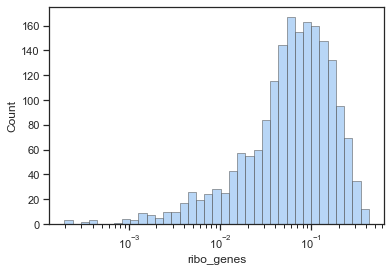

In [9]:
sns.histplot(
    data.obs,
    x="ribo_genes",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)

Literally following instructions from geosketch

In [10]:
tX = data.X # np.transpose(X)
U, s, Vt = pca(tX, k=100)
U.shape

(3962, 100)

In [17]:
Vt.shape

(100, 18467)

In [11]:
X_dimred = U[:, :100] * s[:100]
X_dimred

array([[-4.78534974, -0.88264914, -0.58763868, ..., -0.6183208 ,
         0.1407267 ,  0.10345939],
       [ 0.26332499, 10.15326954,  4.76591243, ..., -1.6224969 ,
         0.33364384,  0.11601119],
       [ 6.38045408,  3.29000283,  0.18726958, ..., -0.2207119 ,
        -0.83256532,  1.22203295],
       ...,
       [-1.10105909,  3.17267408, -7.2317233 , ..., -0.6633557 ,
        -0.14978319, -0.10303811],
       [-5.51707762,  5.18107162,  6.71693804, ...,  1.11341184,
        -2.78164404, -1.17526668],
       [ 0.1167807 ,  9.53812151,  5.68516292, ...,  0.33768409,
         0.22561341, -0.69518677]])

In [12]:
# 50% of cells
N = int(data.shape[0]/2)
sketch_index = gs(X_dimred, N, replace=False)

X_sketch = X_dimred[sketch_index]
X_sketch

array([[ 0.26332499, 10.15326954,  4.76591243, ..., -1.6224969 ,
         0.33364384,  0.11601119],
       [ 6.38045408,  3.29000283,  0.18726958, ..., -0.2207119 ,
        -0.83256532,  1.22203295],
       [-7.42917881, -0.5000858 , -9.0354874 , ..., -1.02156281,
         1.09220326,  0.31164159],
       ...,
       [-2.35665792,  0.72537271, -7.64990993, ..., -1.31027716,
        -0.35693255,  0.39313495],
       [-1.10105909,  3.17267408, -7.2317233 , ..., -0.6633557 ,
        -0.14978319, -0.10303811],
       [-5.51707762,  5.18107162,  6.71693804, ...,  1.11341184,
        -2.78164404, -1.17526668]])

In [13]:
X_sketch.shape

(1981, 100)

In [14]:
sdata = anndata.AnnData(X_sketch)
sdata

AnnData object with n_obs × n_vars = 1981 × 100

In [15]:
pegasus.calc_signature_score(sdata, signatures="ribosomal_genes_human")

2021-10-08 17:15:06,219 - pegasus.tools.signature_score - INFO - Loaded signatures from GMT file /Users/kancherj/opt/miniconda3/envs/sketch/lib/python3.9/site-packages/pegasus/data_files/ribosomal_genes_human.gmt.
2021-10-08 17:15:06,220 - pegasus.tools.signature_score - INFO - Signature ribo_genes: 0 out of 78 genes are used in signature score calculation.
2021-10-08 17:15:06,222 - pegasus.tools.signature_score - WARNING - Signature ribo_genes has less than 1 genes kept and thus its score calculation is skipped!
2021-10-08 17:15:06,223 - pegasus.tools.signature_score - INFO - Function 'calc_signature_score' finished in 0.02s.


In [16]:
sdata.obsm["sig_background"].shape

(1981, 50)